In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models, layers, Input
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

consume = pd.read_csv('skuName_D2_v3.csv', index_col='DATE', parse_dates=['DATE'])[:-1]
consume = consume.asfreq('d').fillna(0)
consume

,ConsumedQuantity
DATE,
2019-01-02,10.000000
2019-01-03,23.866684
2019-01-04,24.000000
2019-01-05,24.000000
2019-01-06,24.000000
...,...
2021-08-27,129.966686
2021-08-28,120.000000
2021-08-29,120.000000


In [130]:
class Multichannael():

    def __init__(self, predict_step):
        self.predict_step = predict_step
        self.data = None
        self.trend = None
        self.seasonal = None
        self.resid = None
        self.sliding_data = []
        self.trend_model = None
        self.seasonal_model = None
        self.resid_model = None

    def _decompose(self, series):
        decomposition = seasonal_decompose(series, two_sided=False, extrapolate_trend='freq')
        self.trend = np.array(decomposition.trend)
        self.seasonal = np.array(decomposition.seasonal)
        self.resid = np.array(decomposition.resid)

    def _sliding_window(self):
        for element in [self.trend, self.seasonal, self.resid]:
            df = pd.DataFrame(element)
            columns = [df.shift(i) for i in range(self.predict_step, -self.predict_step, -1)]
            df = pd.concat(columns, axis=1)
            df.fillna(0, inplace=True)
            self.sliding_data.append(df.values[:-(self.predict_step-1)])

    def _scale(self, data):
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler = scaler.fit(data)
        return scaler

    def fit(self, data, epochs, batch_size):
        self.data = data
        train_series = self.data[:-self.predict_step]
        self._decompose(train_series)
        self._sliding_window()

        trend_X = self.sliding_data[0][:, :-self.predict_step]
        trend_y = self.sliding_data[0][:, -self.predict_step:]
        self.scaler_trend_X = self._scale(trend_X)
        scaled_trend_X = self.scaler_trend_X.transform(trend_X)
        self.scaler_trend_y = self._scale(trend_y)
        scaled_trend_y = self.scaler_trend_y.transform(trend_y)
        
        seasonal_X = self.sliding_data[1][:, :-self.predict_step]
        seasonal_y = self.sliding_data[1][:, -self.predict_step:]
        self.scaler_seasonal_X = self._scale(seasonal_X)
        scaled_seasonal_X = self.scaler_seasonal_X.transform(seasonal_X)
        self.scaler_seasonal_y = self._scale(seasonal_y)
        scaled_seasonal_y = self.scaler_seasonal_y.transform(seasonal_y)

        resid_X = self.sliding_data[2][:, :-self.predict_step]
        resid_y = self.sliding_data[2][:, -self.predict_step:]
        self.scaler_resid_X = self._scale(resid_X)
        scaled_resid_X = self.scaler_resid_X.transform(resid_X)
        self.scaler_resid_y = self._scale(resid_y)
        scaled_resid_y = self.scaler_resid_y.transform(resid_y)

        trend_input = Input(shape=(self.predict_step, 1))
        trend1 = layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu')(trend_input)
        trend2 = layers.Bidirectional(layers.LSTM(200, return_sequences=True))(trend1)
        trend_output = layers.TimeDistributed(layers.Dense(1))(trend2)
        self.trend_model = models.Model(inputs=trend_input, outputs=trend_output)
        self.trend_model.compile(loss='mean_squared_error', optimizer='adam')
        # print(self.trend_model.summary())
        self.trend_model.fit(scaled_trend_X, scaled_trend_y, epochs=epochs[0], batch_size=batch_size, verbose=0)

        seasonal_input = Input(shape=(self.predict_step, 1))
        seasonal1 = layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu')(seasonal_input)
        seasonal2 = layers.Bidirectional(layers.LSTM(200, return_sequences=True))(seasonal1)
        seasonal_output = layers.TimeDistributed(layers.Dense(1))(seasonal2)
        self.seasonal_model = models.Model(inputs=seasonal_input, outputs=seasonal_output)
        self.seasonal_model.compile(loss='mean_squared_error', optimizer='adam')
        # print(self.seasonal_model.summary())
        self.seasonal_model.fit(scaled_seasonal_X, scaled_seasonal_y, epochs=epochs[1], batch_size=batch_size, verbose=0)

        resid_input = Input(shape=(self.predict_step, 1))
        resid1 = layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu')(resid_input)
        resid2 = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(resid1)
        resid_output = layers.TimeDistributed(layers.Dense(1))(resid2)
        self.resid_model = models.Model(inputs=resid_input, outputs=resid_output)
        self.resid_model.compile(loss='mean_squared_error', optimizer='adam')
        # print(self.resid_model.summary())
        self.resid_model.fit(scaled_resid_X, scaled_resid_y, epochs=epochs[2], batch_size=batch_size, verbose=0)

    def evaluation(self):
        trend_X = self.sliding_data[0][-1, -self.predict_step:].reshape(1, -1)
        scale_trend_X = self.scaler_trend_y.transform(trend_X)
        seasonal_X = self.sliding_data[1][-1, -self.predict_step:].reshape(1, -1)
        scale_seasonal_X = self.scaler_seasonal_X.transform(seasonal_X)
        resid_X = self.sliding_data[2][-1, -self.predict_step:].reshape(1, -1)
        scale_resid_X = self.scaler_resid_X.transform(resid_X)
        
        trend = np.array([item for sublist in self.trend_model.predict(scale_trend_X, batch_size=1)[0] for item in sublist]).reshape(1, -1)
        seasonal = np.array([item for sublist in self.seasonal_model.predict(scale_seasonal_X, batch_size=1)[0] for item in sublist]).reshape(1, -1)
        resid = np.array([item for sublist in self.resid_model.predict(scale_resid_X, batch_size=1)[0] for item in sublist]).reshape(1, -1)

        trend = self.scaler_trend_y.inverse_transform(trend)
        seasonal = self.scaler_seasonal_y.inverse_transform(seasonal)
        resid = self.scaler_resid_y.inverse_transform(resid)
        
        self.forecast = (trend+seasonal+resid)[0]
        observed = np.array(self.data[-self.predict_step:]).reshape(1,-1)[0]
        rmse = (((self.forecast-observed)**2).mean())**(1/2)
        print('\n')
        print('RMSE:', rmse)

    def plot(self):

        forecast = pd.concat([pd.Series(self.data.iloc[-self.predict_step-1,0]), pd.Series(self.forecast)])
        forecast.index = self.data.index[-self.predict_step-1:]

        plt.figure(figsize=(12,6))
        plt.plot(self.data[:-self.predict_step], label='Past Value', c='gray')
        plt.plot(self.data[-self.predict_step-1:], label='Observed', c='lime')
        plt.scatter(forecast.index[1:], forecast[1:], s=15, c='darkorange')
        plt.plot(forecast, label='Forecasting', color='orange')
        plt.xticks(rotation=45)
        plt.title('Consumed Quantity of SkuName D2_v3, {}\n Multichannel, {}-step Forecasting'.format(forecast.index[0].date(), self.predict_step), size=15)
        plt.xlabel('Date')
        plt.ylabel('Consumed Quantity')
        plt.xlim(datetime.date(2021, 7, 15), datetime.date(2021, 9, 1))
        plt.ylim(100, 180)
        plt.legend()
        plt.savefig('results/{}_multichannel_CNN_LSTM_plot'.format(self.data.index[-self.predict_step-1].date()), bbox_inches='tight', dpi=300)
        plt.show()

        self.forecast_plot = forecast
        self.observed_plot = self.data[-self.predict_step-1:]
        self.past_plot = self.data[:-self.predict_step:]

    def recommendation(self):
        price_for_recom = pd.concat([self.past_plot[-23:], pd.DataFrame(self.forecast_plot[1:], columns = ['ConsumedQuantity'])])
        max_amount = math.ceil(max(price_for_recom['ConsumedQuantity'])/24)
        min_amount = math.floor(min(price_for_recom['ConsumedQuantity'])/24)

        RI_1list = []
        RI_3list = []
        EA_price = 0.13
        RI_1price = 52.92
        RI_3price = 33.61
        print('EA Price:', (price_for_recom*EA_price).sum().values[0])
        for i in range(min_amount, max_amount+1):
            EA = price_for_recom-24*i
            EA.loc[EA['ConsumedQuantity']<0, 'ConsumedQuantity'] = 0
            EA_total = (EA*EA_price).sum().values[0]
            print(i, 'RI (1 year)', RI_1price*i+EA_total)
            RI_1list.append(RI_1price*i+EA_total)
            print(i, 'RI (3 year)', RI_3price*i+EA_total)
            RI_3list.append(RI_3price*i+EA_total)
            print('\n')
        recommendation = pd.DataFrame(list(zip(range(min_amount, max_amount+1), RI_1list, RI_3list)), columns =['Amount', 'RI (1 year)', 'RI (3 year)'])
        recommendation['EA Price'] = (price_for_recom*EA_price).sum().values[0]
        self.recommendation = recommendation
        print('For RI (1 year), we recommend you buy {} RI with ${}'.format(range(min_amount, max_amount+1)[np.argmin(RI_1list)], min(np.round(RI_1list,2))))
        print('For RI (3 year), we recommend you buy {} RI with ${}'.format(range(min_amount, max_amount+1)[np.argmin(RI_3list)], min(np.round(RI_3list,2))))

    def output_file(self):
        forecast_plot = pd.DataFrame(self.forecast_plot, columns = ['ConsumedQuantity'])
        observed_plot = self.observed_plot
        past_plot = self.past_plot

        forecast_plot.to_csv('results/{}_LSTM_forecast_plot.csv'.format(self.data.index[-self.predict_step-1].date()))
        observed_plot.to_csv('results/{}_observed_plot.csv'.format(self.data.index[-self.predict_step-1].date()))
        past_plot.to_csv('results/{}_past_plot.csv'.format(self.data.index[-self.predict_step-1].date())) 
        self.recommendation.to_csv('results/{}_LSTM_recommendation.csv'.format(self.data.index[-self.predict_step-1].date()))



RMSE: 4.329522943865152


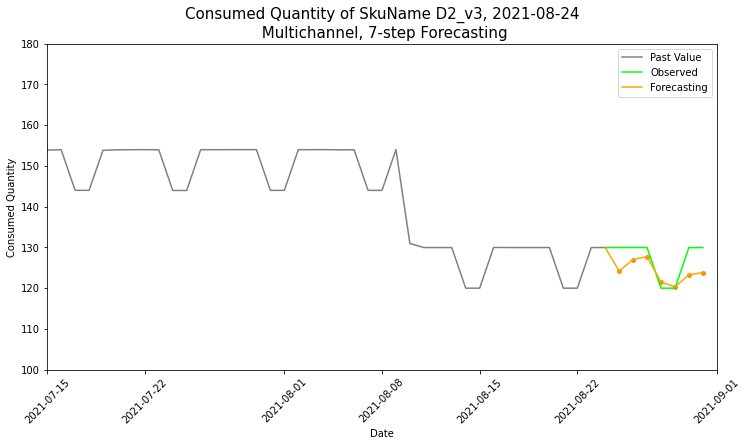

EA Price: 518.7515846776759
5 RI (1 year) 315.35158467767576
5 RI (3 year) 218.80158467767575


6 RI (1 year) 325.29402288
6 RI (3 year) 209.43402288


7 RI (1 year) 370.44
7 RI (3 year) 235.26999999999998


For RI (1 year), we recommend you buy 5 RI with $315.35
For RI (3 year), we recommend you buy 6 RI with $209.43


In [131]:
Multichannael_model = Multichannael(predict_step=7)
Multichannael_model.fit(consume, epochs=[200, 100, 10], batch_size=32)
Multichannael_model.evaluation()
Multichannael_model.plot()
Multichannael_model.recommendation()
Multichannael_model.output_file()



RMSE: 5.9259472023725905


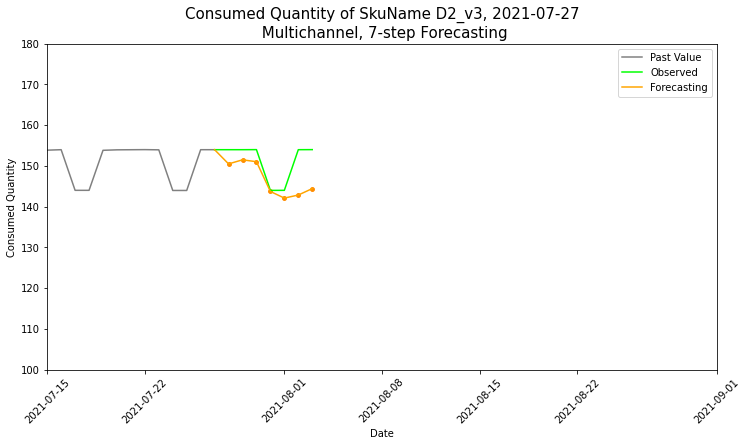

EA Price: 585.9232603149707
5 RI (1 year) 382.5232603149707
5 RI (3 year) 285.97326031497073


6 RI (1 year) 342.2902295145703
6 RI (3 year) 226.43022951457027


7 RI (1 year) 370.44
7 RI (3 year) 235.26999999999998


For RI (1 year), we recommend you buy 6 RI with $342.29
For RI (3 year), we recommend you buy 6 RI with $226.43


RMSE: 8.543469798035558


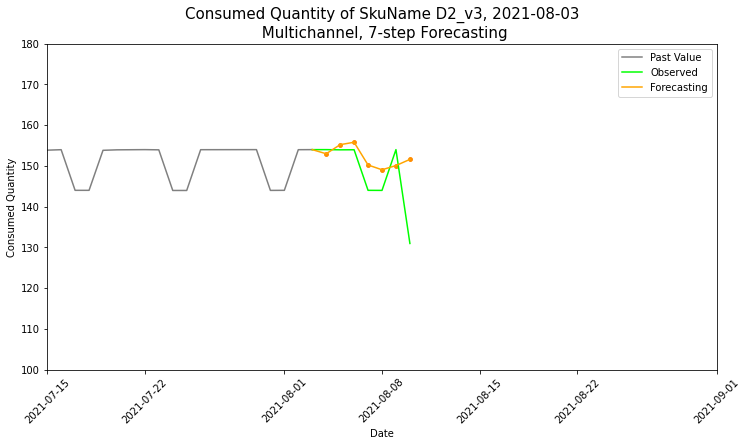

EA Price: 590.9759184284669
5 RI (1 year) 387.57591842846676
5 RI (3 year) 291.02591842846675


6 RI (1 year) 346.90674417846674
6 RI (3 year) 231.04674417846678


7 RI (1 year) 370.44
7 RI (3 year) 235.26999999999998


For RI (1 year), we recommend you buy 6 RI with $346.91
For RI (3 year), we recommend you buy 6 RI with $231.05


RMSE: 15.192512914078751


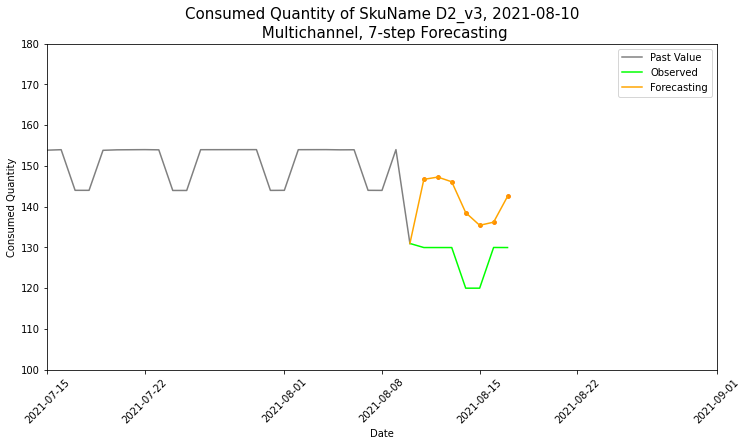

EA Price: 578.609381105869
5 RI (1 year) 375.20938110586917
5 RI (3 year) 278.65938110586916


6 RI (1 year) 339.27154797727536
6 RI (3 year) 223.41154797727538


7 RI (1 year) 370.44
7 RI (3 year) 235.26999999999998


For RI (1 year), we recommend you buy 6 RI with $339.27
For RI (3 year), we recommend you buy 6 RI with $223.41


RMSE: 3.9666527705286634


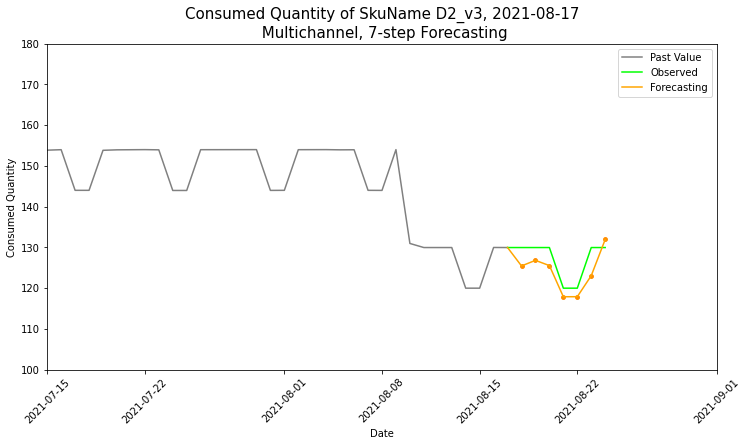

EA Price: 540.6797066319239
4 RI (1 year) 377.95970663192384
4 RI (3 year) 300.7197066319238


5 RI (1 year) 337.82510419967286
5 RI (3 year) 241.27510419967285


6 RI (1 year) 331.77453808999996
6 RI (3 year) 215.91453808999998


7 RI (1 year) 370.44
7 RI (3 year) 235.26999999999998


For RI (1 year), we recommend you buy 6 RI with $331.77
For RI (3 year), we recommend you buy 6 RI with $215.91


In [133]:
Multichannael_model_model = Multichannael(predict_step=7)
Multichannael_model_model.fit(consume[:-28], epochs=[200, 100, 10], batch_size=32)
Multichannael_model_model.evaluation()
Multichannael_model_model.plot()
Multichannael_model_model.recommendation()
Multichannael_model_model.output_file()

Multichannael_model_model = Multichannael(predict_step=7)
Multichannael_model_model.fit(consume[:-21], epochs=[200, 100, 10], batch_size=32)
Multichannael_model_model.evaluation()
Multichannael_model_model.plot()
Multichannael_model_model.recommendation()
Multichannael_model_model.output_file()

Multichannael_model_model = Multichannael(predict_step=7)
Multichannael_model_model.fit(consume[:-14], epochs=[200, 100, 10], batch_size=32)
Multichannael_model_model.evaluation()
Multichannael_model_model.plot()
Multichannael_model_model.recommendation()
Multichannael_model_model.output_file()

Multichannael_model_model = Multichannael(predict_step=7)
Multichannael_model_model.fit(consume[:-7], epochs=[200, 100, 10], batch_size=32)
Multichannael_model_model.evaluation()
Multichannael_model_model.plot()
Multichannael_model_model.recommendation()
Multichannael_model_model.output_file()